# Detecting Human Body Keypoints

Book [Awesome AI: Make Art with Artificial Intelligence](http://kevinashley.com).

In addition, check this deep dive video course [AI in Sports with Python](http://activefitness.ai/ai-in-sports-with-python).



In [1]:
import torch
from torchvision import models

kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


100%|██████████| 226M/226M [00:01<00:00, 154MB/s]


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

Saving back.jpg to back.jpg
User uploaded file "back.jpg" with length 2519616 bytes


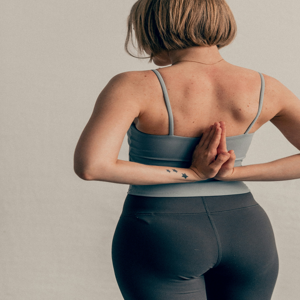

In [2]:
#@title Upload content image

import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os
%matplotlib inline

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
content_img = "content." + fn.split(".")[-1]
!mv -f $fn $content_img

img = Image.open(content_img)
(width, height) = img.size
content_img_max = max(width, height)
content_img_min = min(width, height)

img = Image.open(content_img).resize((300, 300))
display(Image.open(content_img).resize((300, 300)))

In [3]:
import torchvision.transforms as T

def normalize(img):
    normalize_t = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(),
                     T.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)



img_tensor = normalize(img)
detection = kprcnn(img_tensor)[0]
detection

{'boxes': tensor([[8.6276e+01, 1.3925e-01, 1.8945e+02, 3.8450e+01],
         [2.1386e+02, 7.9084e+01, 2.2400e+02, 9.5954e+01],
         [6.7245e+01, 0.0000e+00, 1.9862e+02, 1.1639e+02],
         [5.6728e+01, 8.8370e+01, 2.2311e+02, 2.1891e+02],
         [4.4073e+01, 6.1469e+01, 2.0243e+02, 1.3544e+02],
         [1.2915e+02, 1.3435e+02, 2.2400e+02, 2.2400e+02],
         [2.0425e+02, 7.9736e+01, 2.2352e+02, 1.2501e+02],
         [8.6235e+01, 8.6991e+01, 1.8997e+02, 1.3814e+02],
         [1.9075e+02, 8.5940e+01, 2.2385e+02, 1.2893e+02],
         [1.9563e+02, 8.0767e+01, 2.2400e+02, 9.8575e+01],
         [6.2949e+01, 3.9578e+01, 1.9835e+02, 1.8861e+02],
         [2.1254e+02, 8.0147e+01, 2.2400e+02, 1.1492e+02],
         [2.0950e+02, 4.9230e+01, 2.2364e+02, 9.7269e+01],
         [4.7356e+01, 5.2406e+01, 1.1991e+02, 1.3590e+02]],
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'scores': tensor([0.9245, 0.9201, 0.7319, 0.6287, 0.3931, 0.2988,

In [4]:
def get_keypoint_detections(img, threshold=.7):
    with torch.no_grad():
        img_t = T.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(kprcnn.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = kprcnn(img_t)[0]
    boxes = pred['boxes']
    kpts = pred['keypoints']
    box_scores = pred['scores']
    kpt_scores = pred['keypoints_scores']
    idxs = [i for (i,s) in enumerate(box_scores) if s > threshold]
    res = [(boxes[i].cpu().numpy(),kpts[i].cpu().numpy()) for i in idxs]
    return res

def to_json(preds):
    names = ["nose","left_eye","right_eye","left_ear","right_ear",
            "left_shoulder","right_shoulder","left_elbow","right_elbow",
            "left_wrist","right_wrist","left_hip","right_hip",
            "left_knee","right_knee","left_ankle","right_ankle"]
    detections = [k for (_,k) in preds]
    res = []
    for kpts in detections:
        d = {n:k.round().astype(int).tolist() for (n,k) in zip(names,kpts)}
        res.append(d)
    return json.dumps(res)


In [5]:
keypoint_detections = get_keypoint_detections(img)
json_keypoints = to_json(keypoint_detections)
json_keypoints

'[{"nose": [137, 1, 1], "left_eye": [142, 35, 1], "right_eye": [142, 42, 1], "left_ear": [155, 29, 1], "right_ear": [223, 26, 1], "left_shoulder": [135, 86, 1], "right_shoulder": [272, 90, 1], "left_elbow": [90, 164, 1], "right_elbow": [89, 166, 1], "left_wrist": [192, 173, 1], "right_wrist": [235, 171, 1], "left_hip": [247, 258, 1], "right_hip": [158, 234, 1], "left_knee": [264, 270, 1], "right_knee": [162, 283, 1], "left_ankle": [226, 283, 1], "right_ankle": [151, 283, 1]}]'

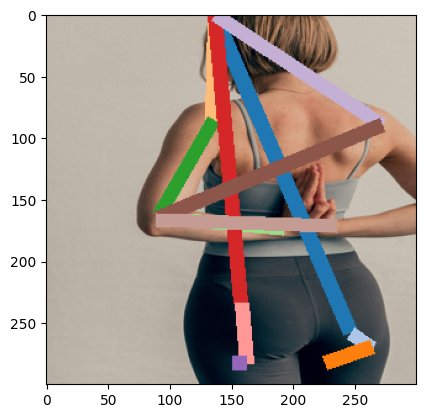

In [12]:
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

def drawline(draw, z, f, t, c):
    if f in z and t in z:
        draw.line((z[f][0], z[f][1], z[t][0], z[t][1]), fill=tuple(c), width=12)

def gen_colors():
    arr = plt.cm.tab20(np.linspace(0, 1, 20))
    arr=arr*255
    return arr.astype(int)

def draw_stickman(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    z = data[0]
    colors = gen_colors()
    drawline(draw, z, 'left_hip', 'nose', colors[0])
    drawline(draw, z, 'left_hip', 'left_knee', colors[1])
    drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
    drawline(draw, z, 'left_shoulder', 'nose', colors[3])
    drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
    drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
    drawline(draw, z, 'right_hip', 'nose', colors[6])
    drawline(draw, z, 'right_hip', 'right_knee', colors[7])
    drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
    drawline(draw, z, 'right_shoulder', 'nose', colors[9])
    drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
    drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
    plt.imshow(img)
    plt.show()

draw_stickman(img, json_keypoints)